In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc3 as pm
import arviz as az

az.style.use('arviz-darkgrid')

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
print(iris['data'].shape)
print(iris['target'].shape)

(150, 4)
(150,)


In [3]:
print(iris['target_names'])
print(iris['feature_names'])

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


![](https://www.w3resource.com/w3r_images/iris_flower_dataset.png)

![](https://www.w3resource.com/w3r_images/iris_flower_sepal_and_petal.png)

In [4]:
# use only sepal length & sepal width for analysys & prediction
selected_features = [0,1] # [2, 3] # for petal
X = iris['data'][:, selected_features]
t = iris['target']
X.shape

(150, 2)

In [5]:
t

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

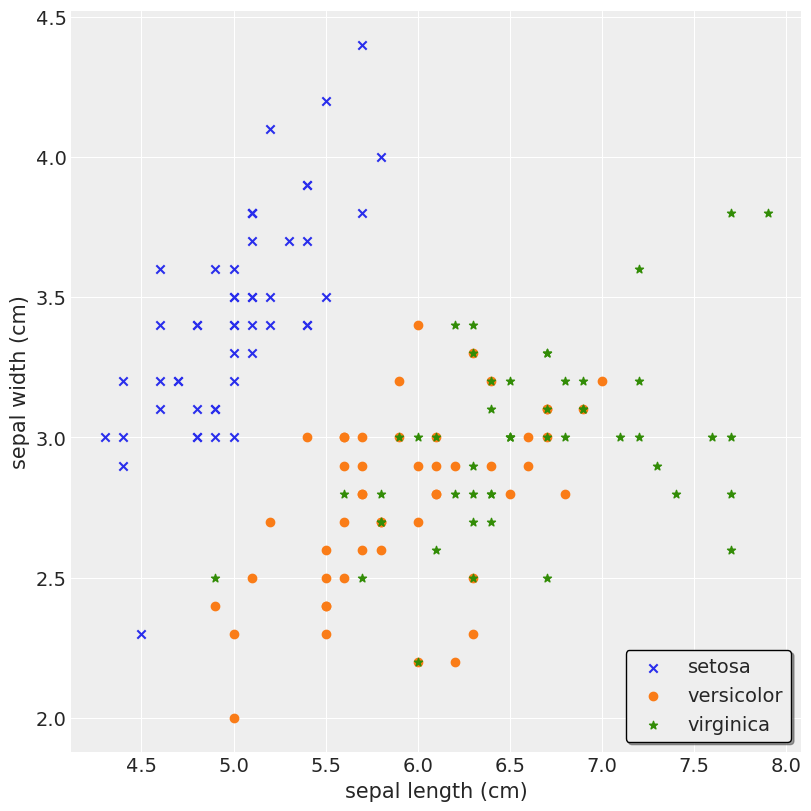

In [6]:
# explore the data

markers = ['x', 'o', '*']
plt.figure(figsize=(8,8))
for k in range(3):
    plt.scatter(X[:,0][t==k], X[:,1][t==k],
                marker=markers[k], label=iris['target_names'][k])
plt.legend(loc='lower right', shadow=True, edgecolor='k', frameon='True')
plt.xlabel(iris['feature_names'][selected_features[0]])
plt.ylabel(iris['feature_names'][selected_features[1]])
plt.show()

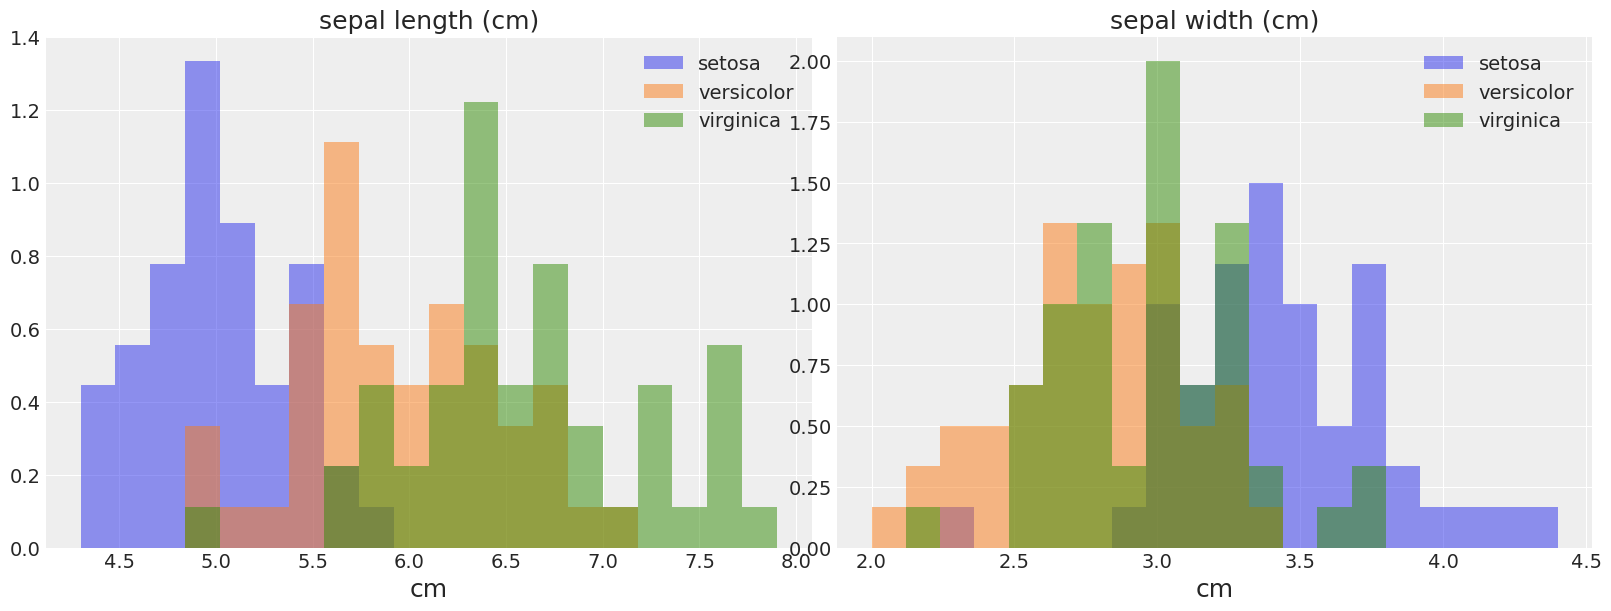

In [7]:
plt.figure(figsize=(16, 6))

# length
plt.subplot(1, 2, 1)
plt.title(iris['feature_names'][selected_features[0]], fontsize=18)
plt.xlabel('cm', fontsize=18)
_, bins, _ = plt.hist(X[:,0][t==0], bins=20, range=[X[:,0].min(), X[:,0].max()], 
                      density=True, alpha=0.5, label=iris['target_names'][0])
plt.hist(X[:,0][t==1], bins=bins, density=True, alpha=0.5, label=iris['target_names'][1])
plt.hist(X[:,0][t==2], bins=bins, density=True, alpha=0.5, label=iris['target_names'][2])
plt.legend()

# width
plt.subplot(1, 2, 2)
plt.title(iris['feature_names'][selected_features[1]], fontsize=18)
plt.xlabel('cm', fontsize=18)
_, bins, _ = plt.hist(X[:,1][t==0], bins=20, range=[X[:,1].min(), X[:,1].max()], 
                      density=True, alpha=0.5, label=iris['target_names'][0])
plt.hist(X[:,1][t==1], bins=bins, density=True, alpha=0.5, label=iris['target_names'][1])
plt.hist(X[:,1][t==2], bins=bins, density=True, alpha=0.5, label=iris['target_names'][2])
plt.legend()

plt.show()

### MCMC approach
Model:

$$
t_i | \mathbf x_i, \mathbf w  \sim 
\mathrm{Categorical}\left( \big. \theta (\mathbf x_i) \right), 
\quad i=1,\ldots, n,
\\
\theta(\mathbf x) = \mathrm{Softmax}(\mathbf w_1^T \mathbf x, \mathbf w_2^T \mathbf x, 0), 
\\
w_{kj} \sim  N(0, S_{kj}), \  k=1, 2, \, j=0,1,2.
$$

In [8]:
# normalize data and append ones
x_means = X.mean(axis=0)
print('x_means=', x_means)
x_scales = X.std(axis=0)
print('x_scales=', x_scales)
zX = (X-x_means)/x_scales
zX = np.hstack([np.ones(shape=(zX.shape[0], 1)), zX])
print('zX.shape=', zX.shape)

zX[:10]

x_means= [5.84333333 3.05733333]
x_scales= [0.82530129 0.43441097]
zX.shape= (150, 3)


array([[ 1.        , -0.90068117,  1.01900435],
       [ 1.        , -1.14301691, -0.13197948],
       [ 1.        , -1.38535265,  0.32841405],
       [ 1.        , -1.50652052,  0.09821729],
       [ 1.        , -1.02184904,  1.24920112],
       [ 1.        , -0.53717756,  1.93979142],
       [ 1.        , -1.50652052,  0.78880759],
       [ 1.        , -1.02184904,  0.78880759],
       [ 1.        , -1.74885626, -0.36217625],
       [ 1.        , -1.14301691,  0.09821729]])

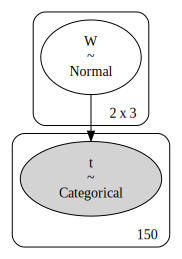

In [9]:
import theano.tensor as tt

with pm.Model() as model:
    W = pm.Normal('W', mu=0, sd=np.array([[10, 2, 2],
                                          [10, 2, 2]]), shape=(2,3))
    mu = tt.concatenate([pm.math.dot(zX, W.T),
                         np.zeros((zX.shape[0], 1))], axis=-1)
    outputs = pm.Categorical('t', tt.nnet.softmax(mu), observed=t)
    
pm.model_to_graphviz(model)

In [10]:
with model:
    trace = pm.sample(draws=2000, tune=1000, chains=2, cores=2,
                      return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [W]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.


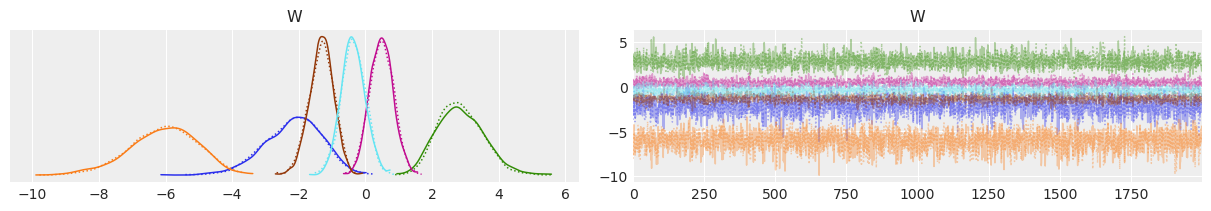

In [11]:
az.plot_trace(trace, var_names=['W']);

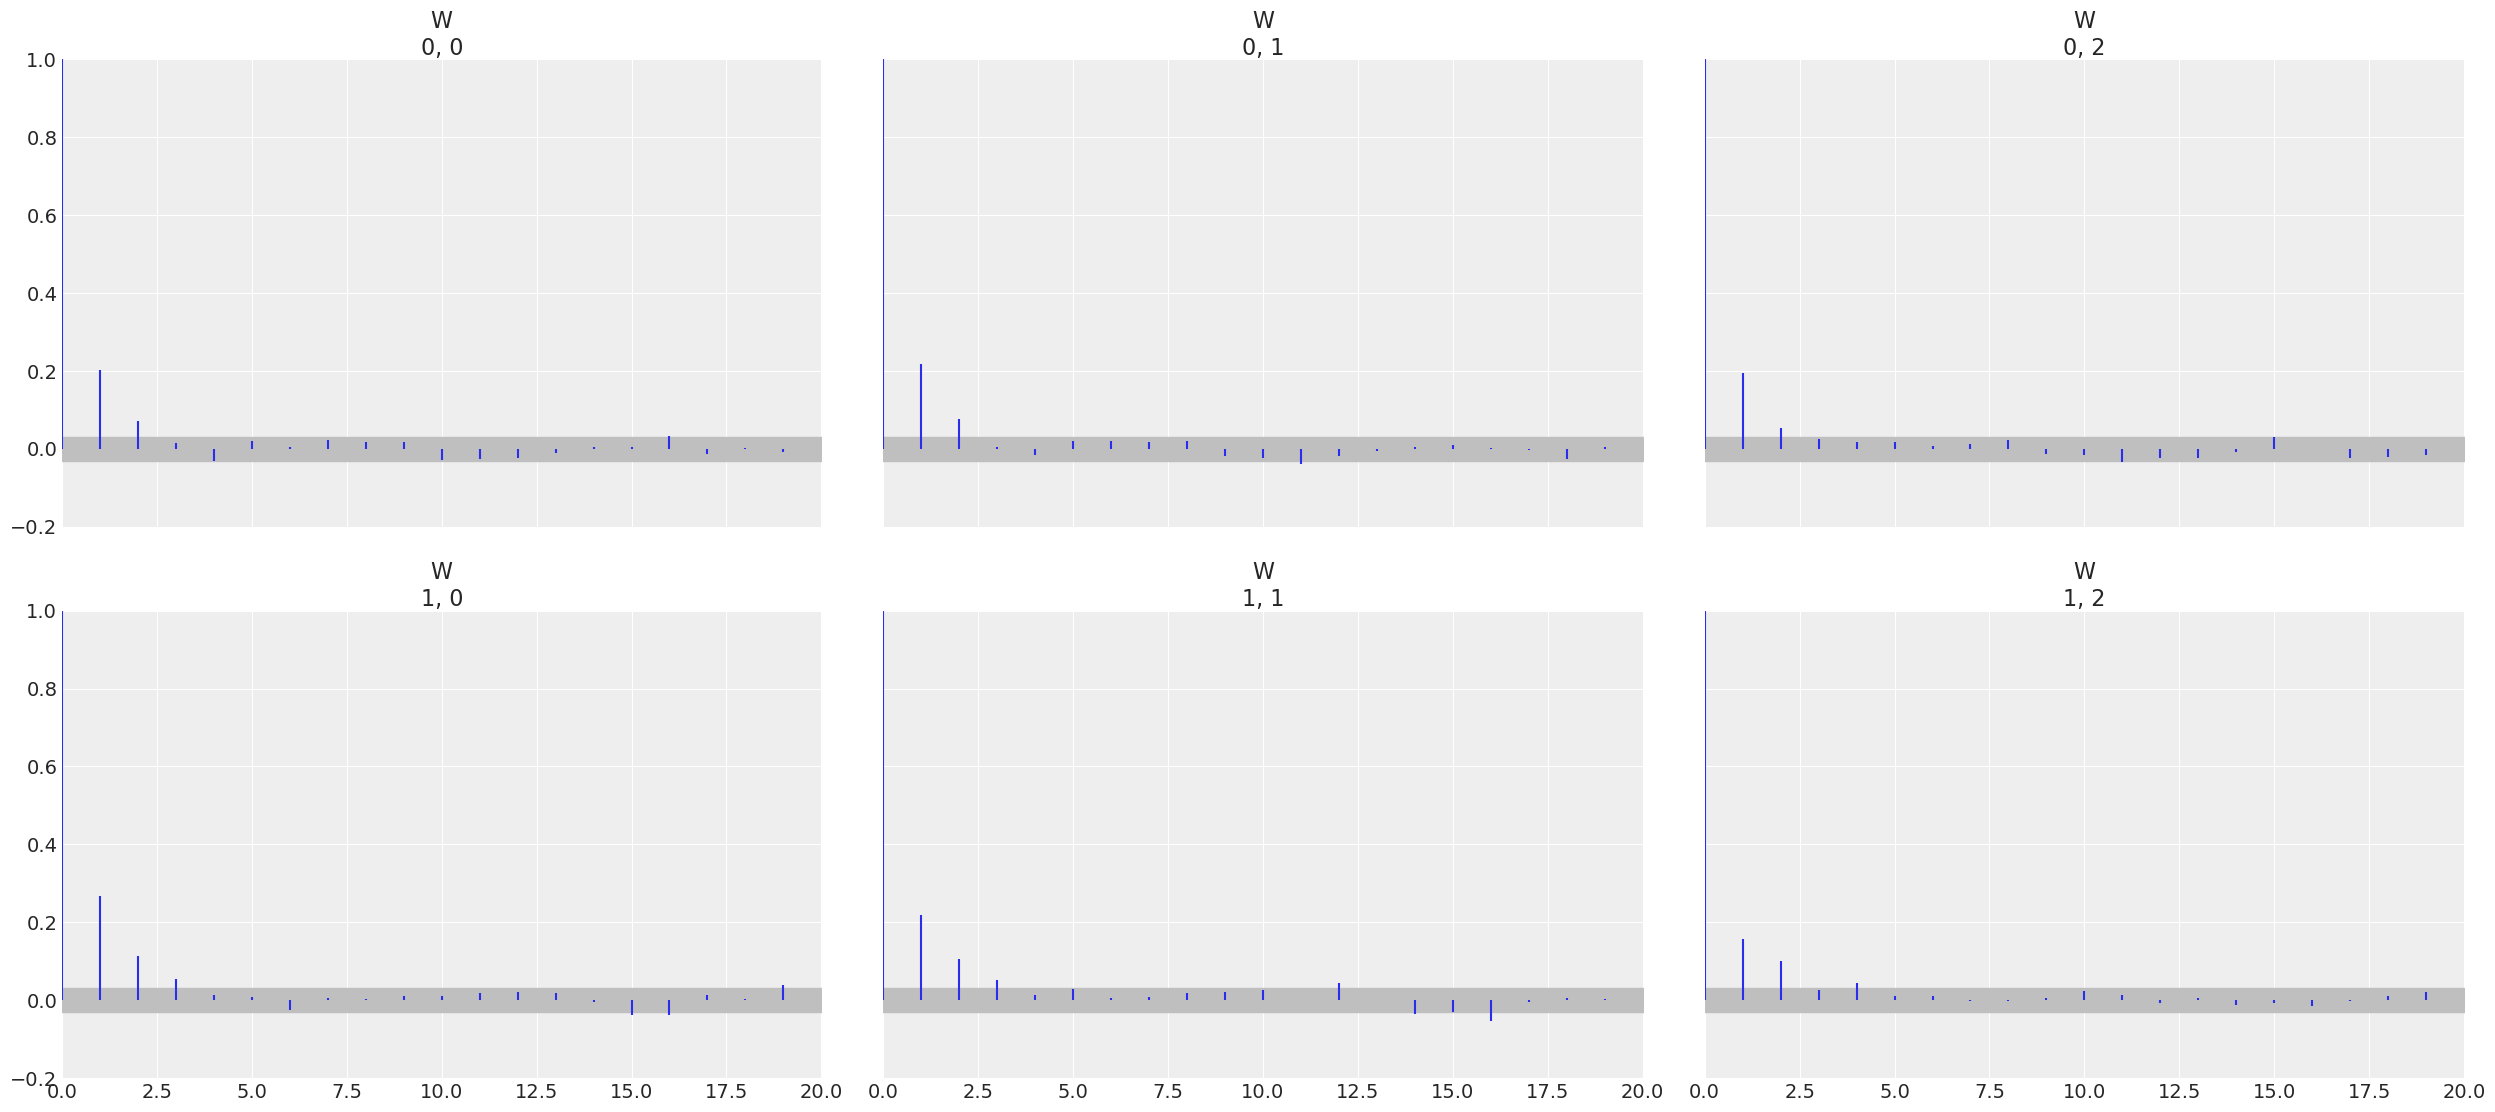

In [12]:
az.plot_autocorr(trace, var_names=['W'], max_lag=20, combined=True)
plt.ylim([-0.2, 1]);

In [13]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0,0]",-2.161,0.866,-3.743,-0.550,0.017,0.012,2568.0,2336.0,1.0
"W[0,1]",-6.068,1.011,-7.939,-4.192,0.020,0.014,2518.0,2524.0,1.0
"W[0,2]",2.863,0.690,1.660,4.134,0.014,0.010,2386.0,2422.0,1.0
"W[1,0]",0.485,0.352,-0.175,1.143,0.008,0.005,2108.0,2419.0,1.0
"W[1,1]",-1.320,0.370,-2.031,-0.662,0.008,0.006,2116.0,2560.0,1.0
"W[1,2]",-0.362,0.361,-1.034,0.321,0.007,0.005,2370.0,2760.0,1.0


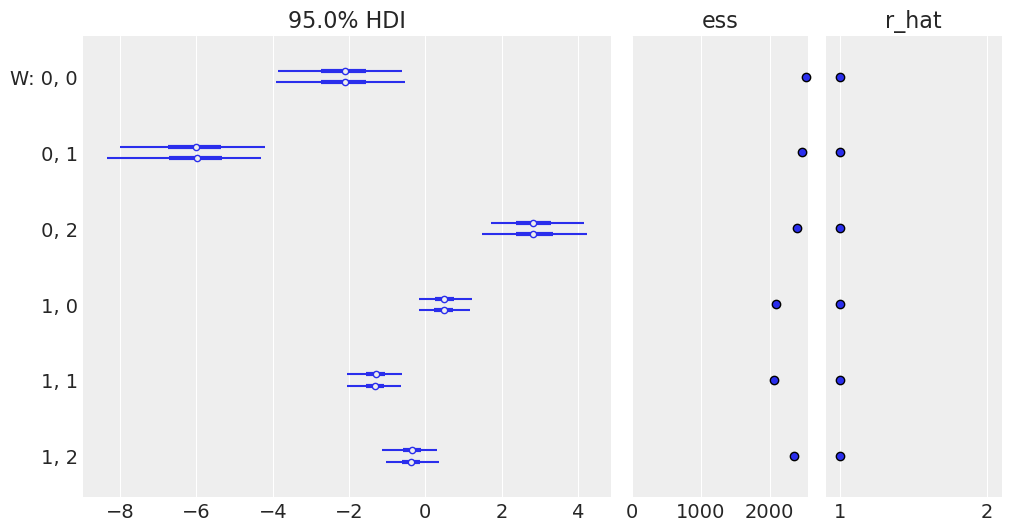

In [14]:
az.plot_forest(trace,
               hdi_prob=0.95,
               r_hat=True, ess=True);

In [15]:
# transform weights back to original scale

w_trace = trace.posterior['W'][0]  # use only 0-ths chain

for k in range(w_trace.shape[1]):
    w_trace[:, k, 0] = w_trace[:, k, 0] \
                     - x_means[0] / x_scales[0] * w_trace[:, k, 1] \
                     - x_means[1] / x_scales[1] * w_trace[:, k, 2]
    w_trace[:, k, 1] /=  x_scales[0]
    w_trace[:, k, 2] /=  x_scales[1]
    
w_trace = np.concatenate([w_trace, 
                          np.zeros(shape=(w_trace.shape[0], 1, w_trace.shape[2]))],
                         axis=1)

In [16]:
w_trace.shape

(2000, 3, 3)

In [17]:
w_trace[2]

array([[23.01310606, -8.69368466,  8.09120626],
       [13.15049298, -1.83294429, -0.63941574],
       [ 0.        ,  0.        ,  0.        ]])

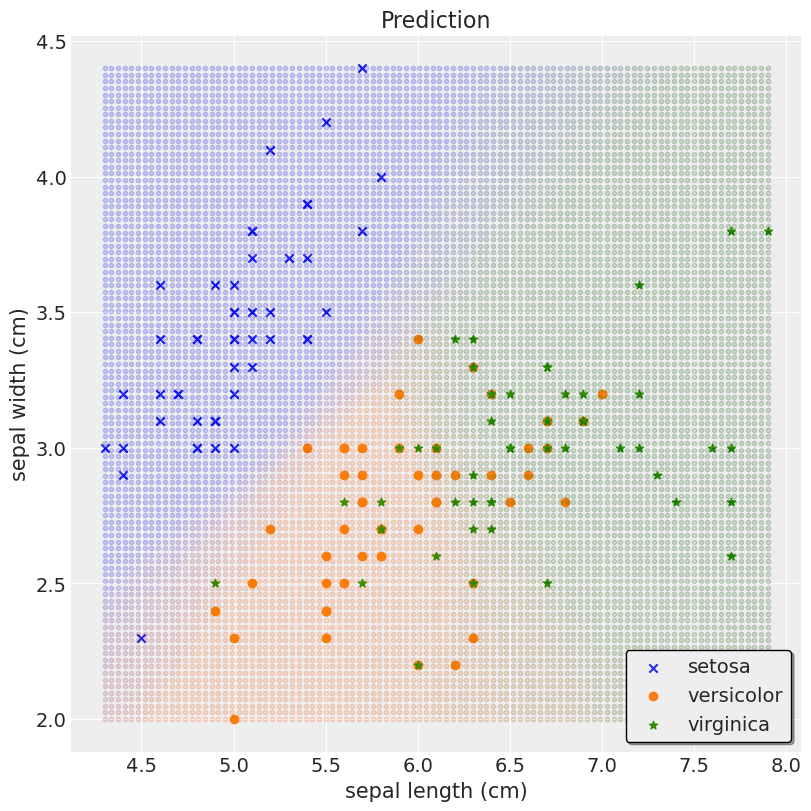

In [18]:
plt.figure(figsize=(8,8))
colors = ['blue', 'orange', 'green']
x_grid = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_grid = np.linspace(X[:,1].min(), X[:,1].max(), 100)
xx, yy = np.meshgrid(x_grid, y_grid)
xx = xx.reshape(np.prod(xx.shape))
yy = yy.reshape(np.prod(yy.shape))
xxx = np.stack([np.ones(xx.shape), xx, yy])


for r in np.arange(0, w_trace.shape[0], 100):  # every 100th step in MC
    M = np.dot(w_trace[r,:,:], xxx)
    t_predict = np.argmax(M, axis=0)
    t_predict.shape
    for k in range(3):
        plt.plot(xx[t_predict==k], yy[t_predict==k], 
                 marker='.', color=colors[k], linestyle='none', alpha=0.006);
        
for k in range(3):
    plt.scatter(X[:,0][t==k], X[:,1][t==k],
                marker=markers[k], label=iris['target_names'][k])
plt.legend(loc='lower right', shadow=True, edgecolor='k', frameon='True')
plt.xlabel(iris['feature_names'][selected_features[0]])
plt.ylabel(iris['feature_names'][selected_features[1]])
plt.title('Prediction');